# Sentiment analysis

In [2]:
from tensorflow.python.platform import build_info as tf_build_info

In [3]:
print(tf_build_info.build_info)
print("cudnn_version",tf_build_info.build_info['cudnn_version'])

print("cuda_version",tf_build_info.build_info['cuda_version'])

OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'), ('cuda_compute_capabilities', ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '12.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
cudnn_version 8
cuda_version 12.2


In [4]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf

## Data analyisis
Kaggle Data: https://www.kaggle.com/datasets/kazanova/sentiment140

In [6]:
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [7]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
len(data)

1600000

In [10]:
data.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [11]:
data['target'].unique()

array([0, 4])

In [12]:
data['target'].value_counts(normalize=True)

target
0    0.5
4    0.5
Name: proportion, dtype: float64

No Data skewing

## Data visualization

In [13]:
positives = data[data['target'] == 4]['text']
negative = data[data['target'] == 0]['text']

In [14]:
sample_pos = positives.sample(frac=0.1, random_state=42)
sample_neg = negative.sample(frac=0.1, random_state=42)

In [15]:
pos_long_text = " ".join([t.lower() for t in sample_pos])
neg_long_text = " ".join([t.lower() for t in sample_neg])

In [16]:
from wordcloud import WordCloud

In [17]:
def plot_wordcloud(long_text: str, title="", size=(800,800)):
    wordcloud = WordCloud(width=size[0], height=size[1], max_words=300, background_color="white", repeat=False, normalize_plurals=True).generate(long_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")

    plt.show()

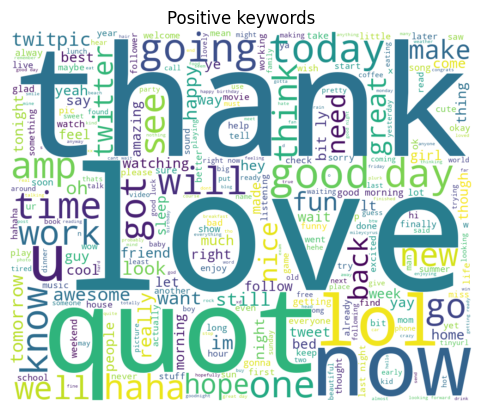

In [18]:
plot_wordcloud(pos_long_text, title="Positive keywords", size=(1000, 800))

Most used positive words
* love
* thank
* quot

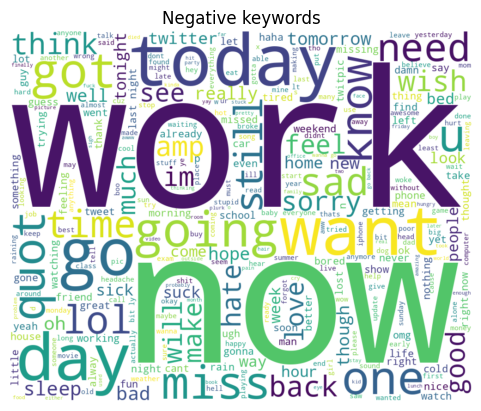

In [19]:
plot_wordcloud(neg_long_text, title="Negative keywords", size=(1000, 800))

Most used negative words
* now
* work
* today

## Data spliting

Using smaller dataset for faster parameter tuning

In [20]:
sample_size = 10000
pos_df = data[data['target'] == 4].sample(n=sample_size, random_state=42)
neg_df = data[data['target'] == 0].sample(n=sample_size, random_state=42)

small_df = pd.concat([pos_df, neg_df])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train_full, X_test, y_train_full, y_test = train_test_split(small_df['text'], small_df['target'], test_size=0.2, random_state=42)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

## Data preperation

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), lowercase=True, stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train).todense()
X_val_vect = vectorizer.transform(X_val).todense()

In [26]:
np.sum(X_train_vect.getA(), axis=1)

array([2.43860912, 2.38401996, 1.        , ..., 1.95339554, 1.70364149,
       1.        ])

In [27]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [28]:
label_encoder = LabelEncoder()

In [29]:
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_val_encoded = to_categorical(label_encoder.transform(y_val))

## Model

In [30]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential

### One Inner layer

In [32]:
X_train_vect.shape[1]*10

10000

In [33]:
def createSeqModel(hidden_layer_size: int):
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(X_train_vect.shape[1], ), activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [42]:
model_seq = createSeqModel(50)
print(tf.config.list_physical_devices('GPU'))
with tf.device("/GPU:0"):
    history = model_seq.fit(X_train_vect, y_train_encoded, epochs=10, batch_size=20, validation_data=(X_val_vect, y_val_encoded), verbose=1)

0.033 0.004


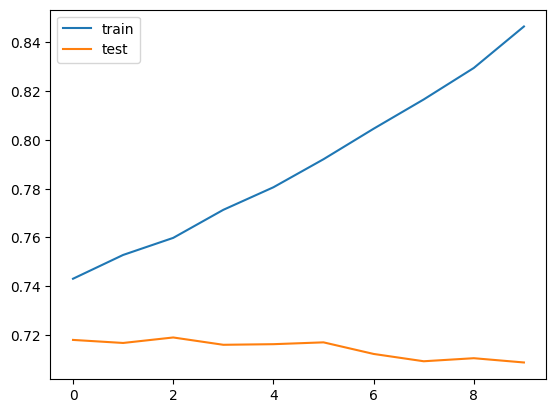

In [47]:
print(round(np.std(history.history['accuracy']), 3), round(np.std(history.history['val_accuracy']), 3))
sns.lineplot(history.history['accuracy'], label="train")
sns.lineplot(history.history['val_accuracy'], label="test")
plt.show()

In [51]:
def get_ith_history(i):
    print(history.history['accuracy'][i], history.history['val_accuracy'][i])

In [52]:
get_ith_history(2)

0.7598333358764648 0.718999981880188


In [53]:
model_seq = createSeqModel(20)
print(tf.config.list_physical_devices('GPU'))
with tf.device("/GPU:0"):
    history = model_seq.fit(X_train_vect, y_train_encoded, epochs=10, batch_size=20, validation_data=(X_val_vect, y_val_encoded), verbose=1)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.6247 - accuracy: 0.6598 - val_loss: 0.5508 - val_accuracy: 0.7178
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.5289 - accuracy: 0.7311 - val_loss: 0.5403 - val_accuracy: 0.7230
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5092 - accuracy: 0.7422 - val_loss: 0.5419 - val_accuracy: 0.7230
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5002 - accuracy: 0.7503 - val_loss: 0.5475 - val_accuracy: 0.7220
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.4940 - accuracy: 0.7527 - val_loss: 0.5498 - val_accuracy: 0.7230
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.4881 - accuracy: 0.7531 - val_loss: 0.5545 - val_accuracy: 0.7222
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.4820 

In [55]:
def plot(history):
    print(round(np.std(history.history['accuracy']), 3), round(np.std(history.history['val_accuracy']), 3))
    sns.lineplot(history.history['accuracy'], label="train")
    sns.lineplot(history.history['val_accuracy'], label="test")
    plt.show()

0.03 0.002


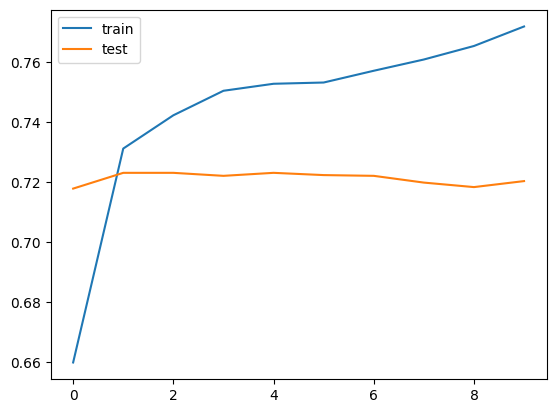

In [56]:
plot(history)

In [57]:
get_ith_history(1)

0.731083333492279 0.7229999899864197


In [61]:
model_seq = createSeqModel(15)
with tf.device("/GPU:0"):
    history = model_seq.fit(X_train_vect, y_train_encoded, epochs=10, batch_size=20, validation_data=(X_val_vect, y_val_encoded), verbose=1)

Epoch 1/10
600/600 [==============================] - 5s 7ms/step - loss: 0.6336 - accuracy: 0.6520 - val_loss: 0.5540 - val_accuracy: 0.7260
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5318 - accuracy: 0.7302 - val_loss: 0.5381 - val_accuracy: 0.7220
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5103 - accuracy: 0.7424 - val_loss: 0.5399 - val_accuracy: 0.7195
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5021 - accuracy: 0.7428 - val_loss: 0.5440 - val_accuracy: 0.7178
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 0.4955 - accuracy: 0.7462 - val_loss: 0.5471 - val_accuracy: 0.7182
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 0.4908 - accuracy: 0.7521 - val_loss: 0.5500 - val_accuracy: 0.7197
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 0.4857 - accuracy: 0.7542 - val_loss: 0.5536 - val_accuracy: 0.7175
Epoch 

0.027 0.002


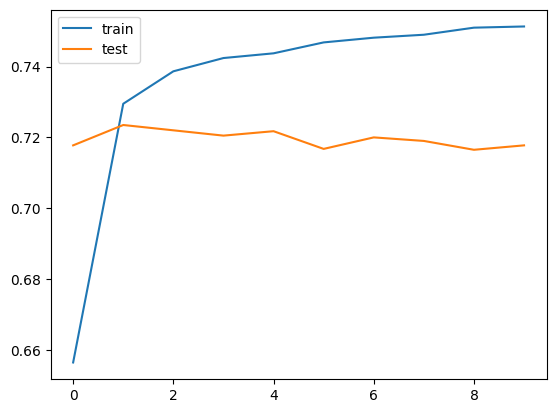

0.7294999957084656 0.7235000133514404


In [60]:
plot(history)
get_ith_history(1)